In [14]:
import time
import gc
import random
import pandas as pd
import numpy as np
# from tqdm import tqdm
import matplotlib.pyplot as plt


# import xgboost as xgb
# from sklearn.metrics import f1_score
# from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

random.seed(42)
gc.enable()
%matplotlib inline

# modeling

### Dask_XGB

https://xgboost.readthedocs.io/en/stable/tutorials/dask.html

https://examples.dask.org/machine-learning/text-vectorization.html

https://examples.dask.org/machine-learning/xgboost.html

In [ ]:
import dask_xgboost

import dask.dataframe as dd
from dask.distributed import Client
import dask_ml.feature_extraction.text
from dask_ml.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
params = {'objective': 'multi:softmax',
          'num_class':20}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=100)

In [ ]:
bst.best_iteration()

In [ ]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_hat

In [ ]:
y_hat.compute()

In [ ]:
y_test, y_hat = dask.compute(y_test, y_hat)

In [ ]:
score = f1_score(y_test, y_hat, average='macro')

### XGBoost with SKlearn wrapper on Dask

In [2]:
from itertools import repeat

import xgboost as xgb
import dask.array as da
import dask.distributed
import dask.dataframe as dd
import dask_ml.feature_extraction.text

from distributed import LocalCluster, Client

In [3]:
def load_data():
    twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
    
    df = dd.from_pandas(pd.DataFrame({"text": twenty_train.data,
                                      "target": twenty_train.target}),
                        npartitions=25)
    
    vect = dask_ml.feature_extraction.text.HashingVectorizer(lowercase=False, ngram_range=(1, 2))
#     vect = dask_ml.feature_extraction.text.CountVectorizer()
    
    y = df['target'].to_dask_array(lengths=True)
    X = vect.fit_transform(df['text'])
    
    X.compute_chunk_sizes()
    y.compute_chunk_sizes()
    
    return X, y


def main(X, y, client: Client) -> None:
    clf = xgb.dask.DaskXGBClassifier(n_estimators=100, tree_method="hist")
    clf.client = client  # assign the client
    clf.fit(X, y, eval_set=[(X, y)])
#     proba = clf.predict_proba(X)

In [4]:
if __name__ == "__main__":
    
    num_exp = 50

    all_exps = []
    exp_time = []
    exp_score = []
    experiment_dict ={}
    experiment_dict["method"] = f"Dask workers=4"   

    X, y = load_data()
    
    with LocalCluster() as cluster:
        with Client(cluster) as client:
            for i in repeat(1, num_exp):
                start = time.time()
                main(X, y, client)
                end = time.time()
                exp_time.append(end-start)

    experiment_dict["time_result"] = exp_time
    all_exps.append(experiment_dict)


INFO:distributed.scheduler:Receive client connection: Client-worker-4118045e-b171-11ed-87a4-3267941770bc
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50485
INFO:distributed.scheduler:Receive client connection: Client-worker-41180710-b171-11ed-87a5-3267941770bc
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50487
INFO:distributed.scheduler:Receive client connection: Client-worker-4118068e-b171-11ed-87a6-3267941770bc
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50486
INFO:distributed.scheduler:Receive client connection: Client-worker-411801a2-b171-11ed-87a7-3267941770bc
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50484
[15:52:30] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[15:52:30] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[15:52:30] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[15:52:30] task [xgboost.dask-3]:tcp://127.0.0.1:50463

[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46661
[2]	validation_0-mlogloss:1.28151
[3]	validation_0-mlogloss:1.14217
[4]	validation_0-mlogloss:1.03220
[5]	validation_0-mlogloss:0.93921
[6]	validation_0-mlogloss:0.85859
[7]	validation_0-mlogloss:0.79099
[8]	validation_0-mlogloss:0.73063
[9]	validation_0-mlogloss:0.67843
[10]	validation_0-mlogloss:0.63418
[11]	validation_0-mlogloss:0.59287
[12]	validation_0-mlogloss:0.55537
[13]	validation_0-mlogloss:0.52197
[14]	validation_0-mlogloss:0.49365
[15]	validation_0-mlogloss:0.46944
[16]	validation_0-mlogloss:0.44421
[17]	validation_0-mlogloss:0.42131
[18]	validation_0-mlogloss:0.39976
[19]	validation_0-mlogloss:0.38100


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[17:00:26] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[17:00:26] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[17:00:26] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[17:00:26] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74618
[1]	validation_0-mlogloss:1.46663
[2]	validation_0-mlogloss:1.28148
[3]	validation_0-mlogloss:1.14215
[4]	validation_0-mlogloss:1.03221
[5]	validation_0-mlogloss:0.93945
[6]	validation_0-mlogloss:0.85882
[7]	validation_0-mlogloss:0.79161
[8]	validation_0-mlogloss:0.73142
[9]	validation_0-mlogloss:0.67911
[10]	validation_0-mlogloss:0.63333
[11]	validation_0-mlogloss:0.59238
[12]	validation_0-mlogloss:0.55533
[13]	validation_0-mlogloss:0.52400
[14]	validation_0-mlogloss:0.49372
[15]	validation_0-mlogloss:0.46607
[16]	validation_0-mlogloss:0.44168
[17]	validation_0-mlogloss:0.41967
[18]	validation_0-mlogloss:0.39855
[19]	validation_0-mlogloss:0.37884


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[18:06:26] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[18:06:26] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[18:06:26] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[18:06:26] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74619
[1]	validation_0-mlogloss:1.46665
[2]	validation_0-mlogloss:1.28265
[3]	validation_0-mlogloss:1.14169
[4]	validation_0-mlogloss:1.03054
[5]	validation_0-mlogloss:0.93611
[6]	validation_0-mlogloss:0.85798
[7]	validation_0-mlogloss:0.79012
[8]	validation_0-mlogloss:0.73077
[9]	validation_0-mlogloss:0.67875
[10]	validation_0-mlogloss:0.63494
[11]	validation_0-mlogloss:0.59518
[12]	validation_0-mlogloss:0.55828
[13]	validation_0-mlogloss:0.52504
[14]	validation_0-mlogloss:0.49592
[15]	validation_0-mlogloss:0.46960
[16]	validation_0-mlogloss:0.44371
[17]	validation_0-mlogloss:0.42130
[18]	validation_0-mlogloss:0.40121
[19]	validation_0-mlogloss:0.37960


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[19:12:37] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[19:12:37] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[19:12:37] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[19:12:37] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46658
[2]	validation_0-mlogloss:1.28148
[3]	validation_0-mlogloss:1.14215
[4]	validation_0-mlogloss:1.03219
[5]	validation_0-mlogloss:0.93920
[6]	validation_0-mlogloss:0.85858
[7]	validation_0-mlogloss:0.79128
[8]	validation_0-mlogloss:0.73138
[9]	validation_0-mlogloss:0.67922
[10]	validation_0-mlogloss:0.63364
[11]	validation_0-mlogloss:0.59340
[12]	validation_0-mlogloss:0.55538
[13]	validation_0-mlogloss:0.52443
[14]	validation_0-mlogloss:0.49373
[15]	validation_0-mlogloss:0.46519
[16]	validation_0-mlogloss:0.44053
[17]	validation_0-mlogloss:0.41892
[18]	validation_0-mlogloss:0.39774
[19]	validation_0-mlogloss:0.37812


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[20:20:09] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[20:20:09] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[20:20:09] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[20:20:09] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74594
[1]	validation_0-mlogloss:1.46642
[2]	validation_0-mlogloss:1.28020
[3]	validation_0-mlogloss:1.14081
[4]	validation_0-mlogloss:1.02747
[5]	validation_0-mlogloss:0.93598
[6]	validation_0-mlogloss:0.85411
[7]	validation_0-mlogloss:0.78793
[8]	validation_0-mlogloss:0.73203
[9]	validation_0-mlogloss:0.68013
[10]	validation_0-mlogloss:0.63485
[11]	validation_0-mlogloss:0.59421
[12]	validation_0-mlogloss:0.55699
[13]	validation_0-mlogloss:0.52377
[14]	validation_0-mlogloss:0.49421
[15]	validation_0-mlogloss:0.46730
[16]	validation_0-mlogloss:0.44297
[17]	validation_0-mlogloss:0.41930
[18]	validation_0-mlogloss:0.39797
[19]	validation_0-mlogloss:0.37981


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[21:27:42] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[21:27:42] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[21:27:42] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[21:27:42] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74611
[1]	validation_0-mlogloss:1.46639
[2]	validation_0-mlogloss:1.28088
[3]	validation_0-mlogloss:1.14111
[4]	validation_0-mlogloss:1.03091
[5]	validation_0-mlogloss:0.93793
[6]	validation_0-mlogloss:0.85631
[7]	validation_0-mlogloss:0.78884
[8]	validation_0-mlogloss:0.73190
[9]	validation_0-mlogloss:0.68090
[10]	validation_0-mlogloss:0.63514
[11]	validation_0-mlogloss:0.59619
[12]	validation_0-mlogloss:0.55949
[13]	validation_0-mlogloss:0.52747
[14]	validation_0-mlogloss:0.49677
[15]	validation_0-mlogloss:0.46864
[16]	validation_0-mlogloss:0.44425
[17]	validation_0-mlogloss:0.42062
[18]	validation_0-mlogloss:0.39958
[19]	validation_0-mlogloss:0.38007


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[22:33:36] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[22:33:36] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[22:33:36] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[22:33:36] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74611
[1]	validation_0-mlogloss:1.46640
[2]	validation_0-mlogloss:1.28109
[3]	validation_0-mlogloss:1.14153
[4]	validation_0-mlogloss:1.03072
[5]	validation_0-mlogloss:0.93727
[6]	validation_0-mlogloss:0.85563
[7]	validation_0-mlogloss:0.78904
[8]	validation_0-mlogloss:0.73005
[9]	validation_0-mlogloss:0.68060
[10]	validation_0-mlogloss:0.63433
[11]	validation_0-mlogloss:0.59448
[12]	validation_0-mlogloss:0.55933
[13]	validation_0-mlogloss:0.52542
[14]	validation_0-mlogloss:0.49585
[15]	validation_0-mlogloss:0.46881
[16]	validation_0-mlogloss:0.44489
[17]	validation_0-mlogloss:0.42239
[18]	validation_0-mlogloss:0.40114
[19]	validation_0-mlogloss:0.38174


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[23:39:22] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[23:39:22] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[23:39:22] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[23:39:22] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74611
[1]	validation_0-mlogloss:1.46658
[2]	validation_0-mlogloss:1.28248
[3]	validation_0-mlogloss:1.14133
[4]	validation_0-mlogloss:1.03072
[5]	validation_0-mlogloss:0.93674
[6]	validation_0-mlogloss:0.85696
[7]	validation_0-mlogloss:0.79059
[8]	validation_0-mlogloss:0.72885
[9]	validation_0-mlogloss:0.67701
[10]	validation_0-mlogloss:0.63245
[11]	validation_0-mlogloss:0.59136
[12]	validation_0-mlogloss:0.55485
[13]	validation_0-mlogloss:0.52312
[14]	validation_0-mlogloss:0.49281
[15]	validation_0-mlogloss:0.46642
[16]	validation_0-mlogloss:0.44291
[17]	validation_0-mlogloss:0.41977
[18]	validation_0-mlogloss:0.39758
[19]	validation_0-mlogloss:0.37779


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[00:45:18] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[00:45:18] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[00:45:18] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[00:45:18] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46660
[2]	validation_0-mlogloss:1.28146
[3]	validation_0-mlogloss:1.14202
[4]	validation_0-mlogloss:1.03196
[5]	validation_0-mlogloss:0.93887
[6]	validation_0-mlogloss:0.85821
[7]	validation_0-mlogloss:0.79046
[8]	validation_0-mlogloss:0.72982
[9]	validation_0-mlogloss:0.67939
[10]	validation_0-mlogloss:0.63436
[11]	validation_0-mlogloss:0.59387
[12]	validation_0-mlogloss:0.55850
[13]	validation_0-mlogloss:0.52482
[14]	validation_0-mlogloss:0.49564
[15]	validation_0-mlogloss:0.46813
[16]	validation_0-mlogloss:0.44403
[17]	validation_0-mlogloss:0.42026
[18]	validation_0-mlogloss:0.39910
[19]	validation_0-mlogloss:0.37855


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[01:50:44] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[01:50:44] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[01:50:44] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[01:50:44] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74603
[1]	validation_0-mlogloss:1.46610
[2]	validation_0-mlogloss:1.28198
[3]	validation_0-mlogloss:1.14099
[4]	validation_0-mlogloss:1.03006
[5]	validation_0-mlogloss:0.93774
[6]	validation_0-mlogloss:0.85742
[7]	validation_0-mlogloss:0.78982
[8]	validation_0-mlogloss:0.73245
[9]	validation_0-mlogloss:0.68115
[10]	validation_0-mlogloss:0.63637
[11]	validation_0-mlogloss:0.59632
[12]	validation_0-mlogloss:0.55698
[13]	validation_0-mlogloss:0.52507
[14]	validation_0-mlogloss:0.49518
[15]	validation_0-mlogloss:0.46795
[16]	validation_0-mlogloss:0.44099
[17]	validation_0-mlogloss:0.42022
[18]	validation_0-mlogloss:0.39869
[19]	validation_0-mlogloss:0.38028


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[02:57:59] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[02:57:59] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[02:57:59] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[02:57:59] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46661
[2]	validation_0-mlogloss:1.28151
[3]	validation_0-mlogloss:1.14217
[4]	validation_0-mlogloss:1.03221
[5]	validation_0-mlogloss:0.93922
[6]	validation_0-mlogloss:0.85860
[7]	validation_0-mlogloss:0.79090
[8]	validation_0-mlogloss:0.73060
[9]	validation_0-mlogloss:0.67836
[10]	validation_0-mlogloss:0.63408
[11]	validation_0-mlogloss:0.59241
[12]	validation_0-mlogloss:0.55667
[13]	validation_0-mlogloss:0.52292
[14]	validation_0-mlogloss:0.49395
[15]	validation_0-mlogloss:0.46705
[16]	validation_0-mlogloss:0.44316
[17]	validation_0-mlogloss:0.41936
[18]	validation_0-mlogloss:0.39719
[19]	validation_0-mlogloss:0.37855


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[04:04:49] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[04:04:49] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[04:04:49] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[04:04:49] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46658
[2]	validation_0-mlogloss:1.28148
[3]	validation_0-mlogloss:1.14215
[4]	validation_0-mlogloss:1.03220
[5]	validation_0-mlogloss:0.93921
[6]	validation_0-mlogloss:0.85857
[7]	validation_0-mlogloss:0.79125
[8]	validation_0-mlogloss:0.73139
[9]	validation_0-mlogloss:0.67910
[10]	validation_0-mlogloss:0.63531
[11]	validation_0-mlogloss:0.59338
[12]	validation_0-mlogloss:0.55637
[13]	validation_0-mlogloss:0.52276
[14]	validation_0-mlogloss:0.49297
[15]	validation_0-mlogloss:0.46813
[16]	validation_0-mlogloss:0.44465
[17]	validation_0-mlogloss:0.42015
[18]	validation_0-mlogloss:0.39780
[19]	validation_0-mlogloss:0.37928


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[05:12:05] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[05:12:05] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[05:12:05] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[05:12:05] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74602
[1]	validation_0-mlogloss:1.46708
[2]	validation_0-mlogloss:1.28155
[3]	validation_0-mlogloss:1.14208
[4]	validation_0-mlogloss:1.03259
[5]	validation_0-mlogloss:0.93936
[6]	validation_0-mlogloss:0.86011
[7]	validation_0-mlogloss:0.79050
[8]	validation_0-mlogloss:0.73099
[9]	validation_0-mlogloss:0.67926
[10]	validation_0-mlogloss:0.63457
[11]	validation_0-mlogloss:0.59494
[12]	validation_0-mlogloss:0.55662
[13]	validation_0-mlogloss:0.52518
[14]	validation_0-mlogloss:0.49518
[15]	validation_0-mlogloss:0.46685
[16]	validation_0-mlogloss:0.44404
[17]	validation_0-mlogloss:0.42044
[18]	validation_0-mlogloss:0.39921
[19]	validation_0-mlogloss:0.38116


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[06:18:35] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[06:18:35] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[06:18:35] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[06:18:35] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74618
[1]	validation_0-mlogloss:1.46667
[2]	validation_0-mlogloss:1.28151
[3]	validation_0-mlogloss:1.14216
[4]	validation_0-mlogloss:1.03223
[5]	validation_0-mlogloss:0.93945
[6]	validation_0-mlogloss:0.85834
[7]	validation_0-mlogloss:0.79157
[8]	validation_0-mlogloss:0.73134
[9]	validation_0-mlogloss:0.68013
[10]	validation_0-mlogloss:0.63369
[11]	validation_0-mlogloss:0.59512
[12]	validation_0-mlogloss:0.55766
[13]	validation_0-mlogloss:0.52599
[14]	validation_0-mlogloss:0.49717
[15]	validation_0-mlogloss:0.46925
[16]	validation_0-mlogloss:0.44547
[17]	validation_0-mlogloss:0.42201
[18]	validation_0-mlogloss:0.40039
[19]	validation_0-mlogloss:0.38096


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[07:25:20] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[07:25:20] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[07:25:20] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[07:25:20] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74602
[1]	validation_0-mlogloss:1.46632
[2]	validation_0-mlogloss:1.28108
[3]	validation_0-mlogloss:1.14140
[4]	validation_0-mlogloss:1.03046
[5]	validation_0-mlogloss:0.93741
[6]	validation_0-mlogloss:0.85574
[7]	validation_0-mlogloss:0.78923
[8]	validation_0-mlogloss:0.73108
[9]	validation_0-mlogloss:0.68026
[10]	validation_0-mlogloss:0.63351
[11]	validation_0-mlogloss:0.59207
[12]	validation_0-mlogloss:0.55823
[13]	validation_0-mlogloss:0.52564
[14]	validation_0-mlogloss:0.49583
[15]	validation_0-mlogloss:0.46921
[16]	validation_0-mlogloss:0.44388
[17]	validation_0-mlogloss:0.42218
[18]	validation_0-mlogloss:0.40125
[19]	validation_0-mlogloss:0.38050


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[08:32:52] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[08:32:52] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[08:32:52] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[08:32:52] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46661
[2]	validation_0-mlogloss:1.28151
[3]	validation_0-mlogloss:1.14217
[4]	validation_0-mlogloss:1.03221
[5]	validation_0-mlogloss:0.93922
[6]	validation_0-mlogloss:0.85854
[7]	validation_0-mlogloss:0.79127
[8]	validation_0-mlogloss:0.73143
[9]	validation_0-mlogloss:0.67972
[10]	validation_0-mlogloss:0.63453
[11]	validation_0-mlogloss:0.59284
[12]	validation_0-mlogloss:0.55506
[13]	validation_0-mlogloss:0.52305
[14]	validation_0-mlogloss:0.49410
[15]	validation_0-mlogloss:0.46718
[16]	validation_0-mlogloss:0.44189
[17]	validation_0-mlogloss:0.41910
[18]	validation_0-mlogloss:0.39825
[19]	validation_0-mlogloss:0.37947


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[09:40:18] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[09:40:18] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[09:40:18] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[09:40:18] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74602
[1]	validation_0-mlogloss:1.46632
[2]	validation_0-mlogloss:1.28108
[3]	validation_0-mlogloss:1.14154
[4]	validation_0-mlogloss:1.03058
[5]	validation_0-mlogloss:0.93754
[6]	validation_0-mlogloss:0.85593
[7]	validation_0-mlogloss:0.78924
[8]	validation_0-mlogloss:0.73154
[9]	validation_0-mlogloss:0.67956
[10]	validation_0-mlogloss:0.63452
[11]	validation_0-mlogloss:0.59504
[12]	validation_0-mlogloss:0.55880
[13]	validation_0-mlogloss:0.52631
[14]	validation_0-mlogloss:0.49671
[15]	validation_0-mlogloss:0.47155
[16]	validation_0-mlogloss:0.44455
[17]	validation_0-mlogloss:0.42178
[18]	validation_0-mlogloss:0.39877
[19]	validation_0-mlogloss:0.37933


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[10:49:39] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[10:49:39] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[10:49:39] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[10:49:39] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46661
[2]	validation_0-mlogloss:1.28151
[3]	validation_0-mlogloss:1.14217
[4]	validation_0-mlogloss:1.03220
[5]	validation_0-mlogloss:0.93921
[6]	validation_0-mlogloss:0.85859
[7]	validation_0-mlogloss:0.79129
[8]	validation_0-mlogloss:0.73141
[9]	validation_0-mlogloss:0.67938
[10]	validation_0-mlogloss:0.63483
[11]	validation_0-mlogloss:0.59346
[12]	validation_0-mlogloss:0.55695
[13]	validation_0-mlogloss:0.52399
[14]	validation_0-mlogloss:0.49426
[15]	validation_0-mlogloss:0.46750
[16]	validation_0-mlogloss:0.44448
[17]	validation_0-mlogloss:0.42046
[18]	validation_0-mlogloss:0.40012
[19]	validation_0-mlogloss:0.38084


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[11:59:42] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[11:59:42] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[11:59:42] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[11:59:42] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74602
[1]	validation_0-mlogloss:1.46632
[2]	validation_0-mlogloss:1.28107
[3]	validation_0-mlogloss:1.14152
[4]	validation_0-mlogloss:1.03056
[5]	validation_0-mlogloss:0.93752
[6]	validation_0-mlogloss:0.85591
[7]	validation_0-mlogloss:0.78922
[8]	validation_0-mlogloss:0.73152
[9]	validation_0-mlogloss:0.67954
[10]	validation_0-mlogloss:0.63444
[11]	validation_0-mlogloss:0.59495
[12]	validation_0-mlogloss:0.55825
[13]	validation_0-mlogloss:0.52612
[14]	validation_0-mlogloss:0.49592
[15]	validation_0-mlogloss:0.47099
[16]	validation_0-mlogloss:0.44578
[17]	validation_0-mlogloss:0.42211
[18]	validation_0-mlogloss:0.39992
[19]	validation_0-mlogloss:0.38077


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[13:15:48] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[13:15:48] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[13:15:48] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[13:15:48] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74611
[1]	validation_0-mlogloss:1.46712
[2]	validation_0-mlogloss:1.28071
[3]	validation_0-mlogloss:1.14153
[4]	validation_0-mlogloss:1.03016
[5]	validation_0-mlogloss:0.93735
[6]	validation_0-mlogloss:0.85690
[7]	validation_0-mlogloss:0.78930
[8]	validation_0-mlogloss:0.73254
[9]	validation_0-mlogloss:0.67893
[10]	validation_0-mlogloss:0.63372
[11]	validation_0-mlogloss:0.59383
[12]	validation_0-mlogloss:0.55631
[13]	validation_0-mlogloss:0.52308
[14]	validation_0-mlogloss:0.49424
[15]	validation_0-mlogloss:0.46672
[16]	validation_0-mlogloss:0.44170
[17]	validation_0-mlogloss:0.41939
[18]	validation_0-mlogloss:0.39861
[19]	validation_0-mlogloss:0.37882


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[14:28:02] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[14:28:02] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[14:28:02] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[14:28:02] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74602
[1]	validation_0-mlogloss:1.46632
[2]	validation_0-mlogloss:1.28110
[3]	validation_0-mlogloss:1.14126
[4]	validation_0-mlogloss:1.03073
[5]	validation_0-mlogloss:0.93767
[6]	validation_0-mlogloss:0.85637
[7]	validation_0-mlogloss:0.78971
[8]	validation_0-mlogloss:0.73213
[9]	validation_0-mlogloss:0.68026
[10]	validation_0-mlogloss:0.63439
[11]	validation_0-mlogloss:0.59479
[12]	validation_0-mlogloss:0.56051
[13]	validation_0-mlogloss:0.52936
[14]	validation_0-mlogloss:0.49933
[15]	validation_0-mlogloss:0.47230
[16]	validation_0-mlogloss:0.44714
[17]	validation_0-mlogloss:0.42333
[18]	validation_0-mlogloss:0.40284
[19]	validation_0-mlogloss:0.38455


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[15:34:57] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[15:34:57] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[15:34:57] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[15:34:57] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74602
[1]	validation_0-mlogloss:1.46632
[2]	validation_0-mlogloss:1.28108
[3]	validation_0-mlogloss:1.14124
[4]	validation_0-mlogloss:1.03072
[5]	validation_0-mlogloss:0.93765
[6]	validation_0-mlogloss:0.85635
[7]	validation_0-mlogloss:0.78937
[8]	validation_0-mlogloss:0.73201
[9]	validation_0-mlogloss:0.67904
[10]	validation_0-mlogloss:0.63362
[11]	validation_0-mlogloss:0.59322
[12]	validation_0-mlogloss:0.55844
[13]	validation_0-mlogloss:0.52645
[14]	validation_0-mlogloss:0.49616
[15]	validation_0-mlogloss:0.46875
[16]	validation_0-mlogloss:0.44458
[17]	validation_0-mlogloss:0.42135
[18]	validation_0-mlogloss:0.40052
[19]	validation_0-mlogloss:0.38096


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[16:40:00] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[16:40:00] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[16:40:00] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[16:40:00] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74618
[1]	validation_0-mlogloss:1.46663
[2]	validation_0-mlogloss:1.28148
[3]	validation_0-mlogloss:1.14215
[4]	validation_0-mlogloss:1.03222
[5]	validation_0-mlogloss:0.93946
[6]	validation_0-mlogloss:0.85816
[7]	validation_0-mlogloss:0.79097
[8]	validation_0-mlogloss:0.73069
[9]	validation_0-mlogloss:0.67893
[10]	validation_0-mlogloss:0.63358
[11]	validation_0-mlogloss:0.59332
[12]	validation_0-mlogloss:0.55523
[13]	validation_0-mlogloss:0.52352
[14]	validation_0-mlogloss:0.49417
[15]	validation_0-mlogloss:0.46663
[16]	validation_0-mlogloss:0.44258
[17]	validation_0-mlogloss:0.41883
[18]	validation_0-mlogloss:0.39897
[19]	validation_0-mlogloss:0.38024


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[17:50:04] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[17:50:04] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[17:50:04] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[17:50:04] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74609
[1]	validation_0-mlogloss:1.46658
[2]	validation_0-mlogloss:1.28151
[3]	validation_0-mlogloss:1.14185
[4]	validation_0-mlogloss:1.03142
[5]	validation_0-mlogloss:0.93673
[6]	validation_0-mlogloss:0.85792
[7]	validation_0-mlogloss:0.78913
[8]	validation_0-mlogloss:0.73047
[9]	validation_0-mlogloss:0.67965
[10]	validation_0-mlogloss:0.63508
[11]	validation_0-mlogloss:0.59519
[12]	validation_0-mlogloss:0.55865
[13]	validation_0-mlogloss:0.52588
[14]	validation_0-mlogloss:0.49742
[15]	validation_0-mlogloss:0.46978
[16]	validation_0-mlogloss:0.44402
[17]	validation_0-mlogloss:0.42049
[18]	validation_0-mlogloss:0.39913
[19]	validation_0-mlogloss:0.38028


INFO:distributed.worker:Run out-of-band function '_start_tracker'
[18:55:26] task [xgboost.dask-0]:tcp://127.0.0.1:50460 got new rank 0
[18:55:26] task [xgboost.dask-1]:tcp://127.0.0.1:50462 got new rank 1
[18:55:26] task [xgboost.dask-2]:tcp://127.0.0.1:50461 got new rank 2
[18:55:26] task [xgboost.dask-3]:tcp://127.0.0.1:50463 got new rank 3


[0]	validation_0-mlogloss:1.74618
[1]	validation_0-mlogloss:1.46667
[2]	validation_0-mlogloss:1.28153
[3]	validation_0-mlogloss:1.14218
[4]	validation_0-mlogloss:1.03225
[5]	validation_0-mlogloss:0.93946
[6]	validation_0-mlogloss:0.85900
[7]	validation_0-mlogloss:0.79167
[8]	validation_0-mlogloss:0.73169
[9]	validation_0-mlogloss:0.68014
[10]	validation_0-mlogloss:0.63389
[11]	validation_0-mlogloss:0.59460
[12]	validation_0-mlogloss:0.55853
[13]	validation_0-mlogloss:0.52624
[14]	validation_0-mlogloss:0.49722
[15]	validation_0-mlogloss:0.47082
[16]	validation_0-mlogloss:0.44629
[17]	validation_0-mlogloss:0.42270
[18]	validation_0-mlogloss:0.40134
[19]	validation_0-mlogloss:0.38143


INFO:distributed.scheduler:Remove client Client-3fda8fa8-b171-11ed-877f-3267941770bc
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:50472; closing.
INFO:distributed.scheduler:Remove client Client-3fda8fa8-b171-11ed-877f-3267941770bc
INFO:distributed.scheduler:Close client connection: Client-3fda8fa8-b171-11ed-877f-3267941770bc
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:50452'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:50453'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:50454'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:50455'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.sc

# Visualize result

In [7]:
# if you ran the notebook
df_result_local = pd.DataFrame(all_exps).set_index("method")
df_result_local = df_result.reset_index()

In [15]:
df_result_local['time_result_avg'] = df_result_local['time_result'].apply(lambda x: np.mean(x))

In [16]:
df_result_local

,index,method,time_result,time_result_avg
0,0,Dask workers=4,"[4076.7535820007324, 3960.8836460113525, 3970....",4054.229888


In [17]:
# if you are loading the result dataframe from file
import ast

df_result = pd.read_csv('../output/df_result_joblib_ray_29012023.csv')
df_result['time_result'] = df_result['time_result'].apply(lambda x: ast.literal_eval(x))

In [18]:
df_result_local

,index,method,time_result,time_result_avg
0,0,Dask workers=4,"[4076.7535820007324, 3960.8836460113525, 3970....",4054.229888


In [ ]:
df_result['average_score'][0]

In [19]:
df_result.head()

,Unnamed: 0,method,time_result,average_score,time_result_avg
0,0,"ray_backend n_job=-1, tree_method=exact","[221.29853296279907, 217.24194288253784, 222.8...","[0.8325888933054486, 0.8325888933054486, 0.832...",218.702716
1,2,"n_job=-1, tree_method=exact","[231.20413184165955, 231.77034091949463, 233.8...","[0.8325888933054486, 0.8325888933054486, 0.832...",233.833133
2,0,"n_job=4, tree_method=exact","[293.35462498664856, 312.37032103538513, 323.1...","[0.8325888933054486, 0.8325888933054486, 0.832...",303.466263
3,3,"n_job=-1, tree_method=hist","[414.09147906303406, 414.3889961242676, 414.22...","[0.8315309242571999, 0.8315309242571999, 0.831...",419.011680
4,1,"n_job=4, tree_method=hist","[462.53806018829346, 458.7789990901947, 458.55...","[0.8315309242571999, 0.8315309242571999, 0.831...",460.887029


In [20]:
df_result = pd.concat([df_result, df_result_local])

In [23]:
df_result = df_result.sort_values(by="time_result_avg")

In [27]:
df_result

,Unnamed: 0,method,time_result,average_score,time_result_avg,index
0,0.0,"ray_backend n_job=-1, tree_method=exact","[221.29853296279907, 217.24194288253784, 222.8...","[0.8325888933054486, 0.8325888933054486, 0.832...",218.702716,NaN
1,2.0,"n_job=-1, tree_method=exact","[231.20413184165955, 231.77034091949463, 233.8...","[0.8325888933054486, 0.8325888933054486, 0.832...",233.833133,NaN
2,0.0,"n_job=4, tree_method=exact","[293.35462498664856, 312.37032103538513, 323.1...","[0.8325888933054486, 0.8325888933054486, 0.832...",303.466263,NaN
3,3.0,"n_job=-1, tree_method=hist","[414.09147906303406, 414.3889961242676, 414.22...","[0.8315309242571999, 0.8315309242571999, 0.831...",419.011680,NaN
4,1.0,"n_job=4, tree_method=hist","[462.53806018829346, 458.7789990901947, 458.55...","[0.8315309242571999, 0.8315309242571999, 0.831...",460.887029,NaN
5,4.0,"n_job=1, tree_method=exact","[1051.6339600086212, 1054.682184934616, 1050.5...","[0.8325888933054486, 0.8325888933054486, 0.832...",1051.518388,NaN
6,5.0,"n_job=1, tree_method=hist","[1225.4195230007172, 1224.7871389389038, 1224....","[0.8315309242571999, 0.8315309242571999, 0.831...",1222.946797,NaN
0,NaN,Dask workers=4,"[4076.7535820007324, 3960.8836460113525, 3970....",NaN,4054.229888,0.0


In [28]:
df_result.columns

Index(['Unnamed: 0', 'method', 'time_result', 'average_score',
       'time_result_avg', 'index'],
      dtype='object')

In [35]:
df_result = df_result.drop(columns=["index", "Unnamed: 0"])
df_result = df_result.set_index("method")

In [42]:
df_result.to_csv('../output/df_result_joblib_ray_dask_21022023.csv', index=True)

In [43]:
df_result = df_result.iloc[[4, -1]]

In [45]:
df_result

,time_result,average_score,time_result_avg
method,,,
"n_job=4, tree_method=hist","[462.53806018829346, 458.7789990901947, 458.55...","[0.8315309242571999, 0.8315309242571999, 0.831...",460.887029
Dask workers=4,"[4076.7535820007324, 3960.8836460113525, 3970....",NaN,4054.229888


In [46]:
4054/460

8.81304347826087

In [ ]:
# df_result = df_result.head(2)

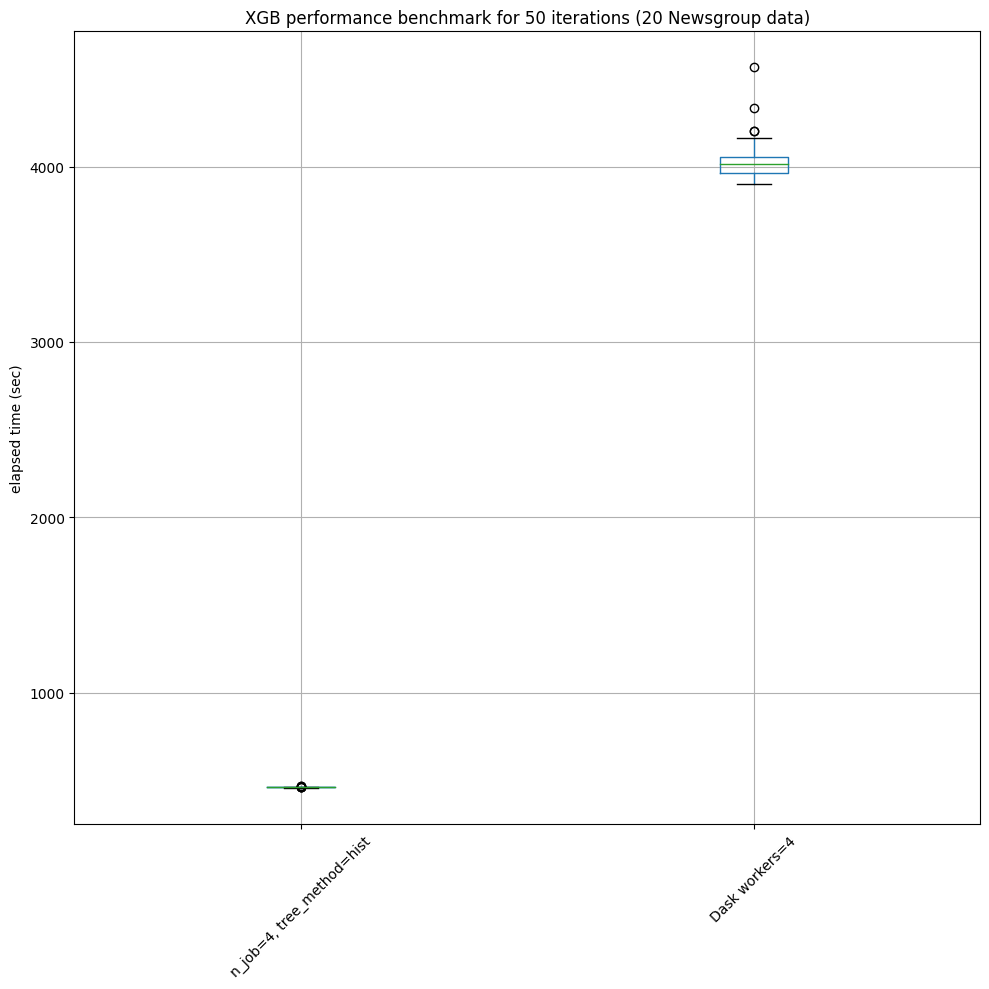

In [44]:
num_exp = 50

fig = plt.figure(figsize=(10, 10))
plt.title(f'XGB performance benchmark for {num_exp} iterations (20 Newsgroup data)')
plt.ylabel("elapsed time (sec)")
fig = df_result["time_result"].apply(lambda x: pd.Series(x)).T.boxplot(rot=45)
plt.tight_layout()
fig.figure.savefig(f'../img/performance_{num_exp}_dask.png')


In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title(f'XGB average time for {num_exp} (20 Newsgroup data)')
plt.ylabel("elapsed time (sec)")

df_result_t = df_result["time_result"].head(2).apply(lambda x: pd.Series(x)).T
fig = df_result_t.reindex(df_result_t.mean().sort_values().index, axis=1).mean().plot(kind='bar', rot=45)

plt.tight_layout()
# fig.figure.savefig(f'../img/average_time_{num_exp}.png')



In [ ]:
# ray https://www.anyscale.com/blog/three-ways-to-speed-up-xgboost-model-training